#  Homework 9 - Berkeley STAT 157

**Your name: XX, SID YY, teammates A,B,C** (Please add your name, SID and teammates to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/)**

Handout 4/18/2019, due 4/25/2019 by 4pm.

This homework deals with sequence models for numbers. It builds on Homework 8 in terms of modeling. The main difference to last week is that we're modeling *real valued numbers* of stocks rather than characters. 

**This is teamwork.**

In [102]:
import d2l
import math
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn, rnn
from mxnet.gluon import data as gdata
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Time Series Model

The goal is to develop multivariate regression models where the numbers are *nonnegative* and where changes are *relative*. That is, a stock price can never assume negative values and for convenience we assume that the companies listed do not go bankrupt, i.e. their stock price will never be zero. Moreover, we assume that we can ignore quantization of prices, i.e. the fact that stocks aren't traded at arbitrary prices in $\mathbb{R}$ but only at fractions of a cent (see [this link for a backstory](https://www.investopedia.com/ask/answers/why-nyse-switch-fractions-to-decimals/)). 

The prices $x_{st}$ for a security $s$ at time $t$ typically reported at a given date are `(open, high, low, close, volume)`. Here `open` denotes the price when the market opens, `high` the highest price that it was traded for during that day, `low` the lowest, and `close` is the price of the security at closing. Lastly `volume` is an indicator for how many units were sold at that day. We index the respective values with $x_{st} = (o, h, l, c, v) \in \mathbb{R}^{5}$. To process them we transform $x_{st}$ as follows:

$$z_{st} := \left(\log o, 10 \cdot (\log h - \log o), 100 \cdot (\log l - \log o), \log c, \log v\right)$$

Moreover, we assume that $z_{st}$ is obtained as part of a regression problem with squared loss, i.e.\ for an estimate $\hat{z}_{st}$ we compute the loss as 

$$l(z_{st}, \hat{z}_{st}) = \frac{1}{2} \|z_{st} - \hat{z}_{st}\|^2$$

1. Why is converting values into logarithms (and logarithms of ratios) a good idea? Explain this for each variable.
1. Why would we want to rescale the ratios by 10?
1. Explain why this model assumes a *lognormal* distribution of prediction errors between the values of the securities ${z}_{st}$ and their estimates $\hat{z}_{st}$. That is, rather than being drawn from a Gaussian, they're drawn from another distribution. Characterize it (hint - exploit the connection between squared loss and the normal distribution).
1. Now assume that we have not just one security but the top 500 stocks over some period of time. Why might it make 
   sense to estimate the share prices jointly? 

## Solution

* Problem 1: Why log    
Generally speaking, log-scale informs on relative changes (multiplicative), while linear-scale informs on absolute changes (additive). And we care about the relative change in the analysis of this question.
    1. $\log(o)$: From the distribution of the price when market opens of the five years, we could tell that the distribution is not normal. Therefore, logrithm    
    2. $\log(h) - \log(o)$: The form is to capture the proportional change of highest price for that day with respect to the 
    3.    
     
        
        
* Problem 2: Why would we want to rescale the ratios by 10?

In [107]:
df = pd.read_csv('all_stocks_5yr.csv')
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


### Example of Logrithm

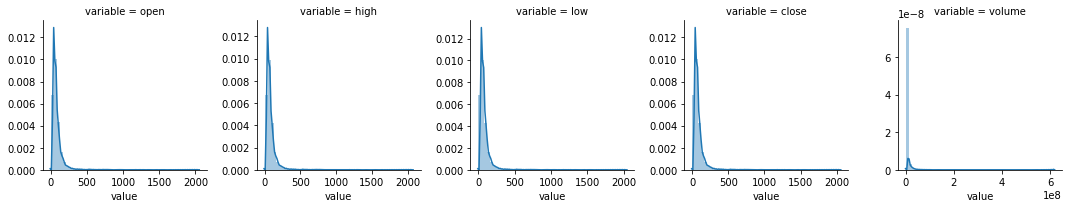

In [36]:
quantitative = [f for f in df1.columns[1:6]]
f = pd.melt(df1, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

In [51]:
df2 = df1.copy()
df2['open'] = np.log(df1['open'])
df2['high'] = 10* (np.log(df1['high']) - np.log(df1['open']))
df2['low'] = 10* (np.log(df1['low']) - np.log(df1['open']))
df2['close'] = np.log(df1['close'])
df2['volume'] = np.log(df1['volume'])

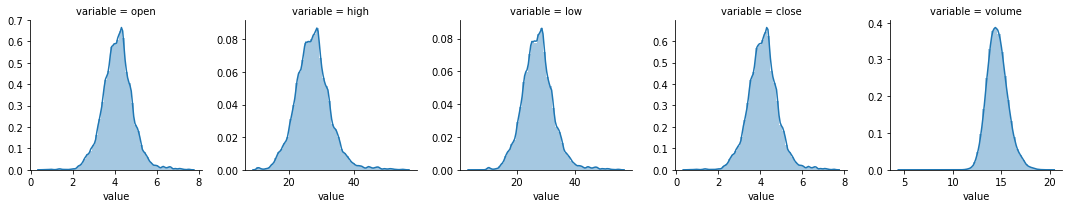

In [45]:
# with rescale 10
quantitative = [f for f in df2.columns[1:6]]
f = pd.melt(df1, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

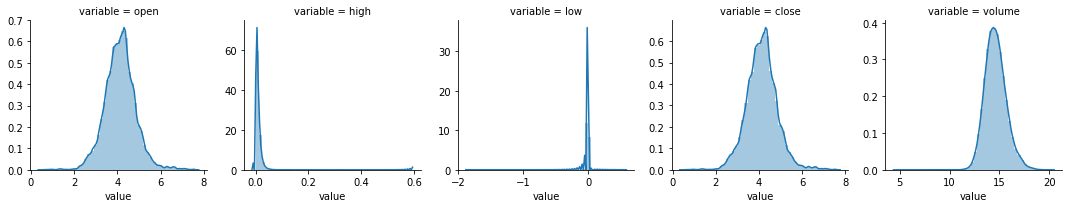

In [52]:
#without rescale
quantitative = [f for f in df2.columns[1:6]]
f = pd.melt(df2, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

## 2. Load Data

1. Obtain data from the S&P500 for the past 5 years and convert it into a time series. You can get the data either from Kaggle [www.kaggle.com/camnugent/sandp500](https://www.kaggle.com/camnugent/sandp500) or crawl it directly using the Python script given here: [github.com/CNuge/kaggle-code/blob/master/stock_data/getSandP.py](https://github.com/CNuge/kaggle-code/blob/master/stock_data/getSandP.py). Your dataset will contain tuples of the form 
`(date, open, high, low, close, volume, Name)`. 
1. Import this data into an NDArray dataset where you have a vector containing `(open, high, low, close, volume)` for each security. That is, this is a 2,500 dimensional vector and you have 5 years' worth of data. 
1. Preprocess the data into logarithmic representation as outlined in problem 1.
1. Split the data into observations for the first 4 years and a dataset for the last year. 
1. Load data into an MXNet dataset iterator.
1. Why do you need to do this as opposed to splitting into random segments?

In [110]:
df1 = df.ffill().copy()

In [113]:
df1['open'] = np.log(df1['open'])
df1['high'] = 10* (np.log(df1['high']) - np.log(df1['open']))
df1['low'] = 10* (np.log(df1['low']) - np.log(df1['open']))
df1['close'] = np.log(df1['close'])
df1['volume'] = np.log(df1['volume'])
df1.loc[:, 'date'] = pd.to_datetime(df1.loc[:,'date'], format="%Y/%m/%d")
df1['year'] = pd.DatetimeIndex(df1['date']).year
df1.head()

,date,open,high,low,close,volume,Name,year
0,2013-02-08,2.712706,17.180717,16.851275,2.691243,15.944635,AAL,2013
1,2013-02-11,2.700690,17.152094,16.639512,2.671386,15.999537,AAL,2013
2,2013-02-12,2.670694,16.924995,16.638363,2.658159,15.910579,AAL,2013
3,2013-02-13,2.660260,17.256185,16.783332,2.685123,16.143715,AAL,2013
4,2013-02-14,2.704042,17.106322,15.824342,2.638343,17.277486,AAL,2013


In [114]:
df2 = df1[df1['year'] == 2018]
df2.to_csv (r'test.csv', index = None, header=True)
df3 = df1[df1['year'] != 2018]
df3.to_csv (r'train.csv', index = None, header=True)

#### Generate Train Feature Matrix

In [115]:
def create_feature(df3):    
    grouped = df3.groupby('date')
    i = 0
    price = nd.zeros((2525, len(grouped)))

    for date, group in grouped:
        rec = grouped.get_group(date).reset_index(drop = True)
        a = rec.iloc[:,1:6].values.flatten()
        price[:len(a),i] = a
        i+=1
    return price

test_feature = create_feature(df2) #test
train_feature = create_feature(df3) #train

print('train feature matrix: \n',train_feature)
print('test feature matrix: \n',test_feature)

train feature matrix: 
 
[[ 2.712706   2.7006898  2.6706944 ...  3.9665112  3.9598603  3.9592881]
 [17.180717  17.152094  16.924995  ... 25.901382  25.870775  25.908257 ]
 [16.851276  16.639511  16.638363  ... 25.7451    25.792568  25.753717 ]
 ...
 [ 0.         0.         0.        ... 28.25052   28.238503  28.2227   ]
 [ 0.         0.         0.        ...  4.2828965  4.2820683  4.2772217]
 [ 0.         0.         0.        ... 13.963733  13.473722  14.34856  ]]
<NDArray 2525x1233 @cpu(0)>
test feature matrix: 
 
[[ 3.9575698  3.9676468  3.960432  ...  3.9510515  3.8983297  3.9300594]
 [25.965467  25.894737  26.20011   ... 25.84734   25.810337  25.822044 ]
 [25.736887  25.741276  25.799738  ... 25.330288  25.269772  25.610119 ]
 ...
 [28.142883  28.150318  28.246767  ... 28.252508  28.229082  28.307703 ]
 [ 4.2734666  4.278054   4.2840004 ...  4.301765   4.2941513  4.302171 ]
 [14.574242  14.660737  14.745314  ... 14.901385  15.409698  15.327316 ]]
<NDArray 2525x26 @cpu(0)>


#### Data Loader and Iterator  
* Why not randomly splitting? Because they are relevant with respect to time. 

In [116]:
train_data = gdata.dataset.ArrayDataset(train_feature)
train_iter = gdata.DataLoader(train_data, batch_size = 64, shuffle = True)

test_data = gdata.dataset.ArrayDataset(test_feature)
test_iter = gdata.DataLoader(test_data, batch_size = 64, shuffle = True)

## 3. Time Series Implementation

1. Implement a model similar to `RNNModel` of section [d2l.ai/chapter_recurrent-neural-networks/rnn-gluon.html](http://en.d2l.ai/chapter_recurrent-neural-networks/rnn-gluon.html) suitable for regression. It should take as input vector-valued data, such as the time series mentioned above and it should output vector-valued data (of some other dimensionality).
1. Train the model on the first 4 years of data using plain RNN, GRU and LSTM cells (for a single layer). How well can the model 
    * Predict the stock value the next day on the last 1 year of data (price at opening).
    * Plot how the quality of the model degrades as we apply it throughout the year (i.e. we ingest all the data up to day $t$ and predict forward at day $t+1$). 
    * Predict the stock value the next week on the last 1 year of data (price at opening).
1. Train the model on each stock separately (with much lower dimensionality) and compare the performance of the above model with the one you get by using each stock separately. 
1. Improve the model using better features, e.g. the fact that time is not uniformly spaced (Saturday, Sunday and holidays do not see any trades). For that use the day of the week as an additional input feature. 
1. Improve the model further by using a deeper RNN, e.g. with 2 layers. 

Note, there are many cases where we might want to know the *sequence* of stock prices over a period of time rather than just knowing the value, say one month from now. This is relevant e.g. for options pricing where investors can bet on or bet against volatility of a stock price. For a detailed description of this see e.g. [en.wikipedia.org/wiki/Options_strategy](https://en.wikipedia.org/wiki/Options_strategy).